# CONCRETE STRENGTH PREDICTION
## NOTEBOOK SUMMARY
1. Statistical report 
2. Univariate and multivariate analysis 
3. Checking for missing values 
4. Extra features such as water-cement radius
5. Model building is done with hyper parameter tuning and the feature importance is also shown.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import randint

In [3]:
dataset=pd.read_csv('concrete.csv')

# summary of the dataset (statistical report)

In [10]:
ProfileReport(dataset)

1. We can see that in each column, has less unique values, cause there is specific ratio to be used to make the grade (depending on the required concrete strength)
2. There are duplicate rows present in the dataset.
3. The skewness can also be seen in the graph detail skewness determination will be done but from here we can see that the dataset features does not have normal distribution.
4. In correlation graph we can see that strength correlated with superplastic, cement and age.
5. There is no missing values present in the dataset.
6. Even though there is no missing values, the columns such as ash, and superplastic is having zeros as the entry.
    This is because they are not used in all the concrete mmaking, it is used when the concrete is made for heavy machinary holding building or used in the design mi of higher grade(above M50). 
7. from the skewness plot we can see that::
    1. cement  :  Right skewed 0.5087389156389815
    2. slag  :  Right skewed 0.7995503309986298
    3. ash  :  Right skewed 0.5365710347923704
    4. water  :  Right skewed 0.07451965817729818
    5. superplastic  :  Right skewed 0.9058808712519942
    6. coarseagg  : left skewed -0.04016114865669757
    7. fineagg  : left skewed -0.2526409879628909
    8. age  :  Right skewed 3.264414535416805
    9. strength  :  Right skewed 2.1456670020474835

## 5-Number summary of the dataset

In [9]:
dataset.describe()

cement         slag          ash        water  superplastic  \
count  1030.000000  1030.000000  1030.000000  1030.000000   1030.000000   
mean    281.167864    73.895825    54.188350   181.567282      6.204660   
std     104.506364    86.279342    63.997004    21.354219      5.973841   
min     102.000000     0.000000     0.000000   121.800000      0.000000   
25%     192.375000     0.000000     0.000000   164.900000      0.000000   
50%     272.900000    22.000000     0.000000   185.000000      6.400000   
75%     350.000000   142.950000   118.300000   192.000000     10.200000   
max     540.000000   359.400000   200.100000   247.000000     32.200000   

         coarseagg      fineagg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730.950000     7.000000    23.710000  
50%     968.000000   779.500000    28.000000    34.445000  
75%    1029.400000   824.000000    56.000000    46.135000  
max    1145.000000   992.600000   365.000000    82.600000

Here we can check the summary of the dataset with all columns together.
1. The range of the columns are different since this is a regression problem it has to be scaled for linear models.
2. The mean and the std distribution and the quantitle details are presented for all columns together for better view.

# distribution plot
(FOR BETTER VIEW)

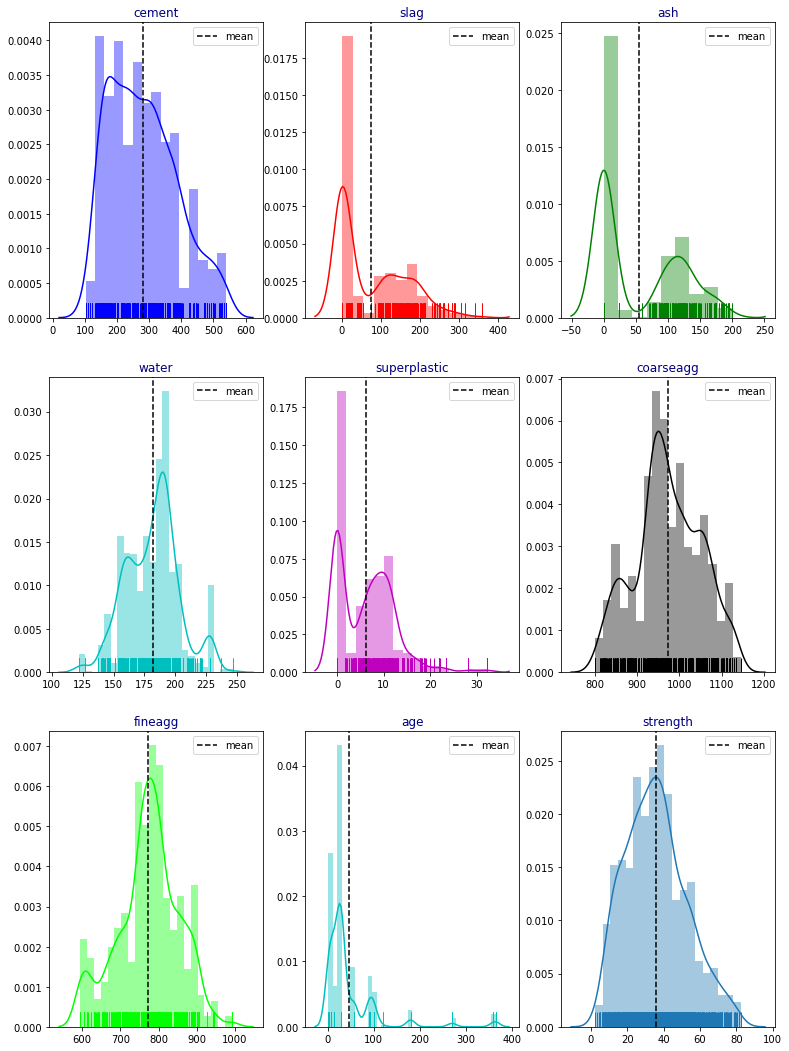

In [4]:
columns=dataset.columns
length = len(columns)
cs = ["b","r","g","c","m","k","lime","c"]
fig = plt.figure(figsize=(13,25))
def ploting(columns,length,cs):
    for i,j,k in itertools.zip_longest(columns,range(length),cs):
        plt.subplot(4,3,j+1)
        ax = sns.distplot(dataset[i],color=k,rug=True)
        ax.set_facecolor("w")
        plt.axvline(dataset[i].mean(),linestyle="dashed",label="mean",color="k")
        plt.legend(loc="best")
        plt.title(i,color="navy")
        plt.xlabel("")
ploting(columns,length,cs)

In [5]:
# MISSING VALUE CHECK CONFIRMATION
dataset.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [6]:
# THE TOTAL NUMBER OF DUPLICATE ROWS PRESENT
dataset.duplicated().sum()

25

In [7]:
# DROPING THE DUPLICATE VALUES
dataset=dataset.drop_duplicates()

In [8]:
# # figure size
plt.figure(figsize=(15,8))

# Usual boxplot
ax = sns.boxplot( x='age',y='strength', data=dataset)
 
# Add jitter with the swarmplot function.
ax = sns.swarmplot(x='age', y='strength', data=dataset, color="grey")

ax.set_title('Box plot of strength with respect to the age')

Text(0.5, 1.0, 'Box plot of strength with respect to the age')

# UNIVARIATE ANALYSIS

 
Deponding on the use of the concrete there are three categories
   1. Ordinary concrete (M5,M7.5,M10,M15,M20)
   2. standard concrete (M25,M30,M35,M40,M45,M50)
   3. High standard concrete (M55,M60,M65,M70)
Usually the strength of the concrete is checked at 7th day that time it attains the 40percent strength and at 28 th day it attains the maximum strength. so we will find the outliers keeping the grade into factor

In [9]:
def grade(value):
    if value <5:
        return 'M5'
    if value>5 and value <=7.5:
        return 'M7.5'
    if value >7.5 and value <=10:
        return 'M10'
    if value> 10 and value <=15:
        return 'M15'
    if value>15 and value <=20:
        return 'M20'
    if value >20 and value <25:
        return 'M10'
    if value> 25 and value <=30:
        return 'M30'
    if value>30 and value <=35:
        return 'M35'
    if value >35 and value <=40:
        return 'M40'
    if value> 40 and value <=45:
        return 'M45'
    if value>45 and value <=50:
        return 'M50'
    if value >50 and value <=55:
        return 'M55'
    if value>55 and value <=60:
        return 'M60'
    if value>60 and value <=65:
        return 'M65'
    if value>65 and value<=70:
        return 'M70'
    else:
        return 'composite'

In [10]:
dataset1=dataset[dataset['age']==28]# we are using the date 28 alone cause it is the standard day for testing
dataset1['grade']=dataset1['strength'].apply(lambda x: grade(x) )

C:\Users\HP-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Which is the majority type of grade used in construction?

Text(0.5, 1.0, 'Distribution of the different grades')

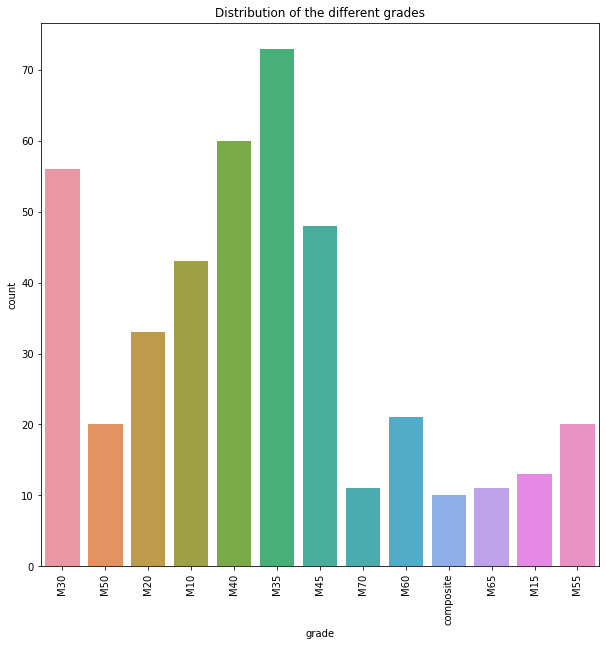

In [11]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sns.countplot(dataset1['grade'])
plt.title("Distribution of the different grades")

M35 is the mostly used concrete type and M7.5 is the less used. so, most of the concrete type belongs to design mix

# what is the amount of cement used based on the grade?

In [12]:
plt.figure(figsize=(10,10))

result = dataset1.groupby(["grade"])['cement'].aggregate(np.median).reset_index().sort_values('cement')
sns.barplot(x='grade', y="cement", data=dataset1, order=result['grade']) 
plt.show()

As the grade increases the amount of the cement used i also increasing

# what is the amount of water required based on the grade?

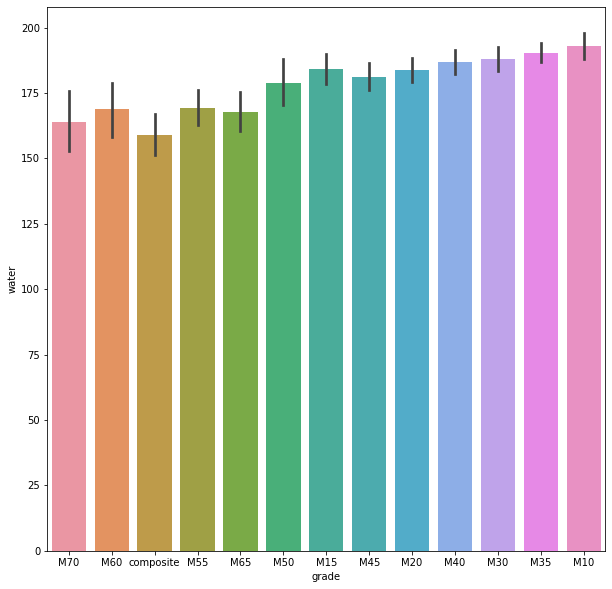

In [13]:
plt.figure(figsize=(10,10))

result = dataset1.groupby(["grade"])['water'].aggregate(np.median).reset_index().sort_values('water')
sns.barplot(x='grade', y="water", data=dataset1, order=result['grade']) 
plt.show()

This is not a good distinguisher, when compared to cement

# STRENGTH BY MONTHS

In [14]:
def age(value):
    if value<=31:
        return "1month"
    if value <=60 and value>31:
        return "2month"
    if value >60 and value<=90:
        return "3month"
    if value >90 and value<=120:
        return "4month"
    if value> 120 and value<=150:
        return "5month"
    if value>150 and value<=180:
        return "6month"
    if value>180 and value<=210:
        return "7month"
    if value>210 and value<=240:
        return "8month"
    if value>240 and value<=270:
        return "9month"
    else:
        return "12month"
dataset['months']=dataset['age'].apply(lambda x: age(x))

In [16]:
dat=dataset.groupby(["months"],as_index=False).mean()
order  = ['1month','2month', '3month','4month','6month','9month', '12month']
fig = plt.figure(figsize=(15,5))
sns.pointplot(dat['months'],dat['strength'],data=dat,
                       order=order,
                       markers="H",
                       linestyles="dotted")


<AxesSubplot:xlabel='months', ylabel='strength'>

# MULTIVARIATE ANALYSIS

In [17]:
plt.figure(figsize=(15,8))
sns.scatterplot(dataset['cement'],dataset['water'])
plt.title('Scatterplot of cement and water')

Text(0.5, 1.0, 'Scatterplot of cement and water')

# cement and strength

In [18]:
plt.figure(figsize=(15,8))
sns.scatterplot(dataset['cement'],dataset['strength'])
plt.title('Scatterplot of cement and strength')

Text(0.5, 1.0, 'Scatterplot of cement and strength')

we can see that there is a linear relationship between the cement and the strength. but it is not a strong linear relationship

# water-cement ratio vs strength

Text(0.5, 1.0, 'Scatterplot of water-cement and strength')

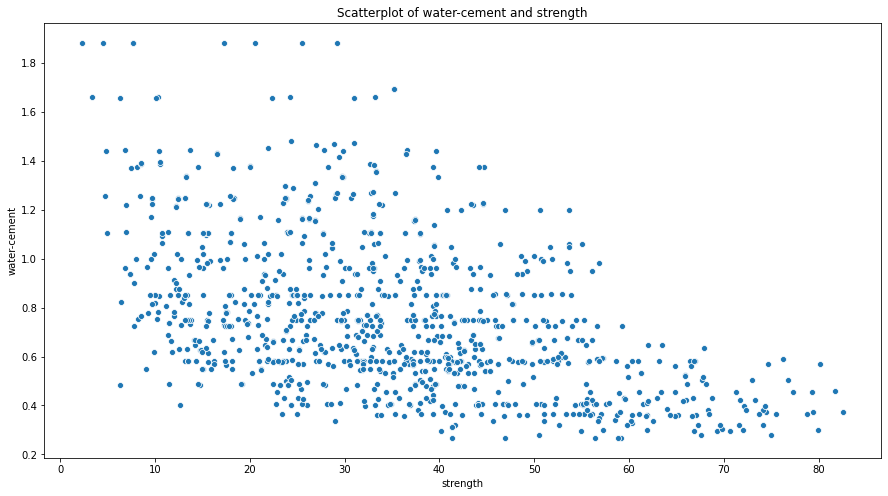

In [19]:

dataset['water-cement']=dataset['water']/dataset['cement']
plt.figure(figsize=(15,8))
sns.scatterplot(dataset['strength'],dataset['water-cement'])
plt.title('Scatterplot of water-cement and strength')

we can see that there is a negative not typicall linear relationship between the water-cement content and the strength

# aggregate-ratio vs strength(coarse (non fine sand))

Text(0.5, 1.0, 'Scatterplot of aggregate-ratio and strength')

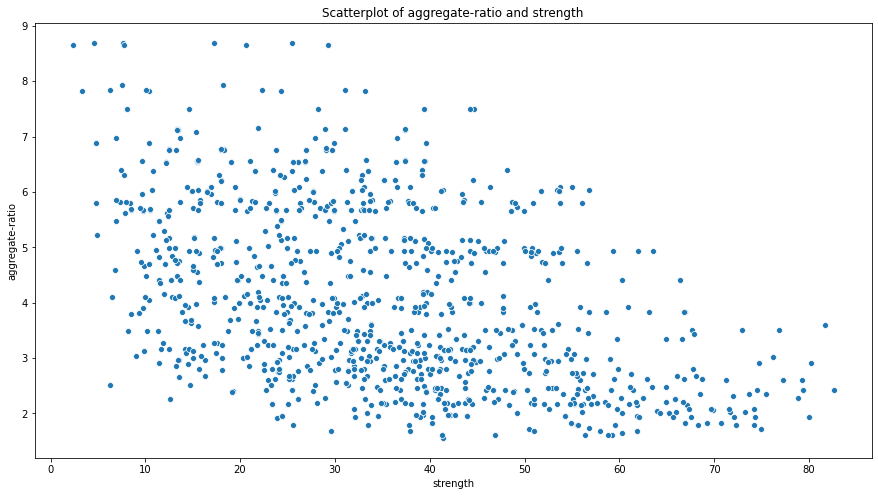

In [20]:
dataset['aggregate-ratio']=dataset['coarseagg']/dataset['cement']
plt.figure(figsize=(15,8))
sns.scatterplot(dataset['strength'],dataset['aggregate-ratio'])
plt.title('Scatterplot of aggregate-ratio and strength')

we can see that there is a negative not typicall linear relationship between the aggregate(coarse-ratio) content and the strength
# aggregate-ratio vs strength(coarse ( fine sand))

Text(0.5, 1.0, 'Scatterplot of aggregate-ratio and strength')

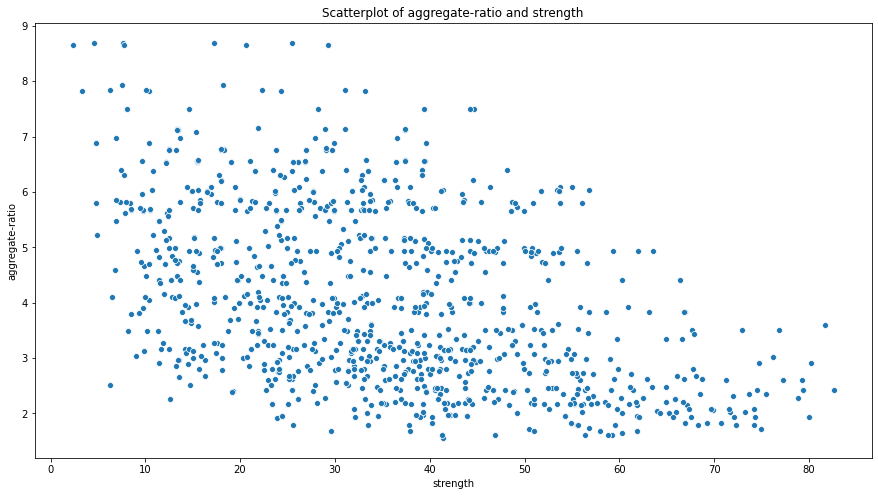

In [21]:
dataset['aggregate-ratio-fine']=dataset['fineagg']/dataset['cement']
plt.figure(figsize=(15,8))
sns.scatterplot(dataset['strength'],dataset['aggregate-ratio'])
plt.title('Scatterplot of aggregate-ratio and strength')

# correlation plot

<AxesSubplot:>

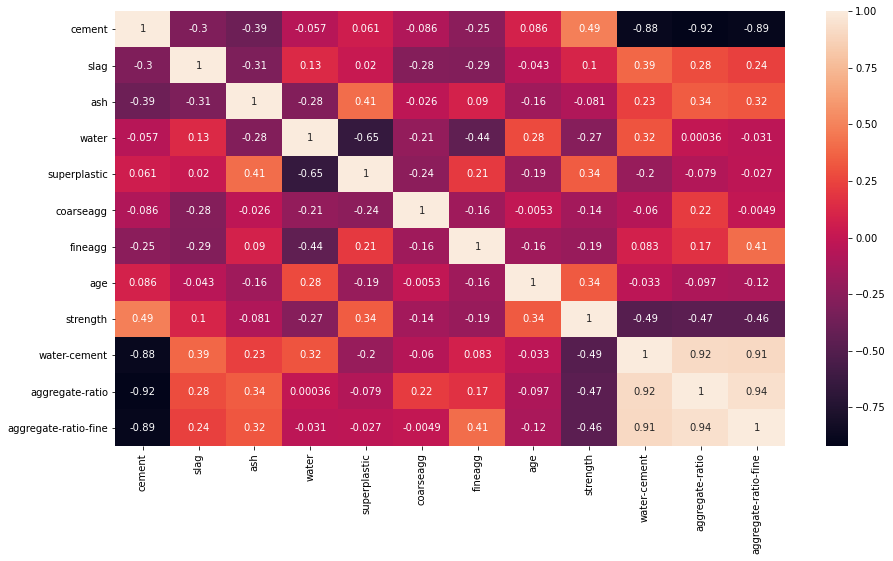

In [22]:
plt.figure(figsize=(15,8))
sns.heatmap(dataset.corr(),annot=True)

# summary of the relationship plot

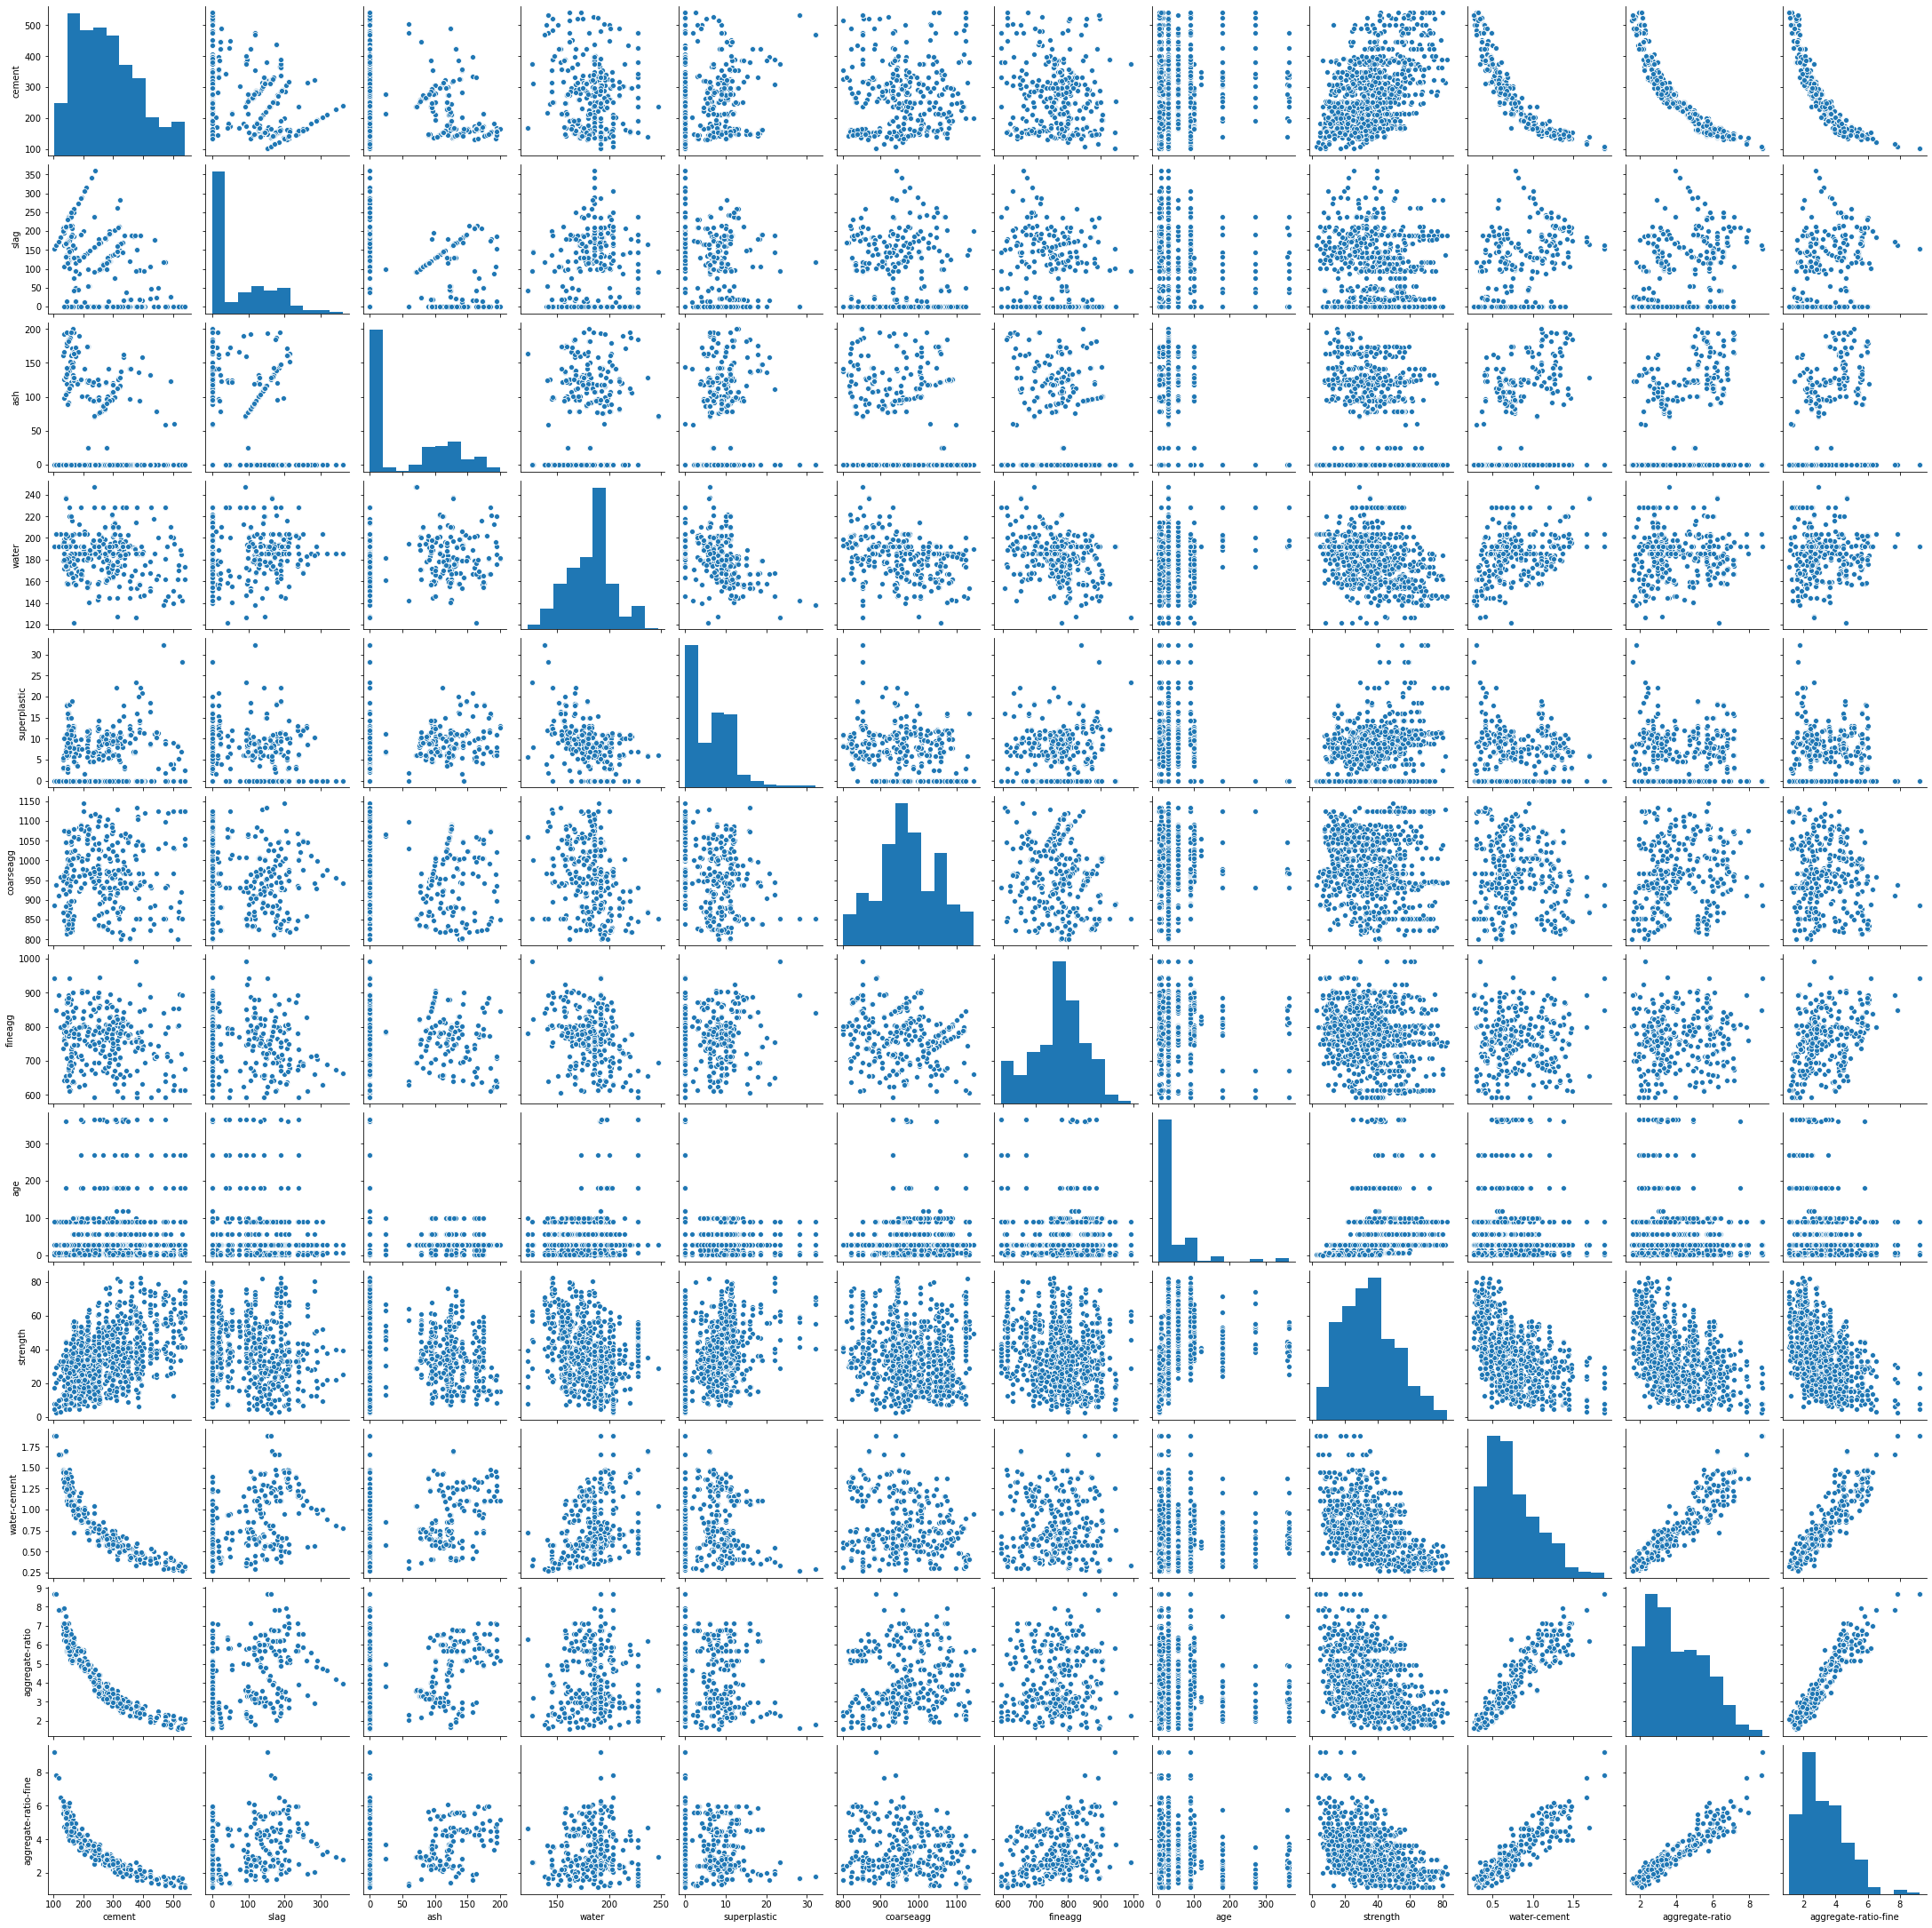

In [23]:
sns.pairplot(dataset)

# MODEL BUILDING
## MODEL DECISION FLOW
1. This problem is supervised learning model. so, unsupervised learning alogorithms are skipped. 
2. The target is not having linear relationship with all the features, and there is also correlation between the features which voilates the assumptions of the linear regression so it is eliminated.
3. KNN and ensemble techniques.
and for KNN the features should be scaled, moreover it is usefull to use when there is a pattern in the dataset.
so we will go for ensemble techniques, so we have 1. Decision tree (which usually overfits) post pruning method has to be used.
2. Random forest and boosting methods. 
3. So, in random forest we will choose the extratreegressor, so that it will have low variance so that it over overfit and it has less bias we will remove the boosting methods which is also a good choice no doubt but we will use simple model. (perfect)

# HYPERPARAMETER TUNING

In [172]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [174]:
etr = ExtraTreesRegressor(n_jobs=-1)
clf = GridSearchCV(etr,random_grid, cv=10)
#dataset=dataset.drop(['months'],axis=1)
best_model = clf.fit(dataset.drop(['strength'],axis=1),dataset['strength'])

KeyboardInterrupt: 

In [154]:
best_model.best_score_

0.9289474419321178

In [156]:
best_model.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 70}

In [161]:
pred=best_model.predict(x_test)

In [165]:
np.sqrt(mean_squared_error(y_test,pred))# root mean squared error

1.8555963707246248

# FEATURE IMPORTANCE

In [27]:
dataset=dataset.drop(['months'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(dataset.drop(['strength'],axis=1),dataset['strength'],test_size=0.2,random_state=20)

In [28]:
model=ExtraTreesRegressor(max_depth= 40,max_features= 'auto',min_samples_leaf=1,min_samples_split= 2,n_estimators= 70)
model.fit(x_train,y_train)

ExtraTreesRegressor(max_depth=40, n_estimators=70)

<AxesSubplot:>

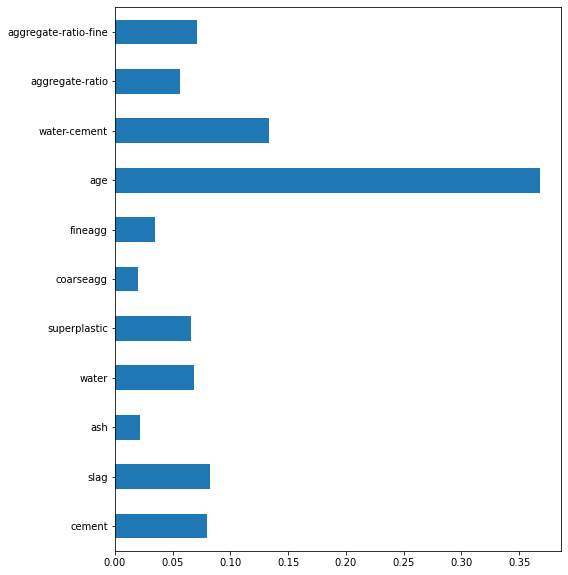

In [29]:
feat_imp = pd.Series(model.feature_importances_, index=x_train.columns)
feat_imp.plot(kind='barh', figsize=(8,10))

# Prediction vs actual plot

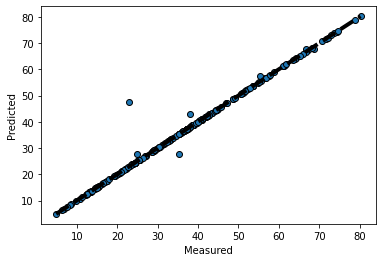

In [171]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# FURTHER EXTENSION
Other ensemble models can be tried, the model can be checked with out of box values to check whether the performance is good are further tuning is required.